<a href="https://colab.research.google.com/github/GreenStreetQuant/LSTM_Stock/blob/master/LSTM_medium_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=e328460ecf79e08207f5eb2aef964e873729a0685edfed6651961e0b2ef522cb
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#using yahoo to fetch the data for RNG
rng = yf.download("RNG", period='max', interval='1d')
rng

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-27,17.250000,19.400000,17.100000,18.200001,18.200001,8127600
2013-09-30,17.980000,18.440001,17.570000,18.020000,18.020000,774900
2013-10-01,18.290001,18.290001,16.700001,17.080000,17.080000,610500
2013-10-02,17.190001,17.280001,16.299999,17.000000,17.000000,840800
2013-10-03,16.820000,17.540001,16.520000,16.910000,16.910000,145600
...,...,...,...,...,...,...
2020-05-11,262.000000,276.609985,261.359985,275.029999,275.029999,1284900
2020-05-12,276.000000,283.230011,269.940002,278.799988,278.799988,1341000
2020-05-13,278.799988,288.920013,271.390015,283.000000,283.000000,2415200


In [0]:
#splitting the data by training & testing 
#only interested in the Close column
total_price = rng['Close']
training_price = total_price.loc[rng.index[:1620]]
testing_price = total_price.loc[rng.index[1620:]]

#converting the training data to array
price_array = np.array(training_price).reshape((len(training_price), 1))

In [0]:
#scaling the training data for optimal performance
scaler = MinMaxScaler(feature_range=(0,1))

rng_training_scaled = scaler.fit_transform(price_array)

In [0]:
#converting to 3D array with 60 timesteps 
#from the training data, assigning features & labels
features_set = []
labels = []
for i in range(60, 1620):
  features_set.append(rng_training_scaled[i-60:i, 0])
  labels.append(rng_training_scaled[i, 0])
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
features_set.shape


(1560, 60, 1)

In [0]:
from keras.layers import LSTM
from keras.layers import Dense 
from keras.layers import Dropout
from keras.models import Sequential

#building the model with 50 units for the output space
#dropping 20% of the layers 
#loss set to mean_squarred_error
#fitting the model to run 50 epochs with a batch size of 32
#metrics set to mae & acc
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'acc'])

In [0]:
model.fit(features_set, labels, epochs=50, batch_size=32)

Epoch 1/50
1560/1560 [==============================] - 25s 16ms/step - loss: 0.0052 - mae: 0.0401 - acc: 0.0013
Epoch 2/50
1560/1560 [==============================] - 24s 15ms/step - loss: 0.0014 - mae: 0.0219 - acc: 0.0013
Epoch 3/50
1560/1560 [==============================] - 24s 15ms/step - loss: 0.0017 - mae: 0.0231 - acc: 0.0013
Epoch 4/50
1560/1560 [==============================] - 24s 15ms/step - loss: 0.0015 - mae: 0.0219 - acc: 0.0013
Epoch 5/50
1560/1560 [==============================] - 24s 15ms/step - loss: 0.0016 - mae: 0.0244 - acc: 0.0013
Epoch 6/50
1560/1560 [==============================] - 24s 15ms/step - loss: 0.0014 - mae: 0.0225 - acc: 0.0013
Epoch 7/50
1560/1560 [==============================] - 24s 15ms/step - loss: 0.0013 - mae: 0.0233 - acc: 0.0013
Epoch 8/50
1560/1560 [==============================] - 24s 15ms/step - loss: 0.0011 - mae: 0.0195 - acc: 0.0013
Epoch 9/50
1560/1560 [==============================] - 24s 15ms/step - loss: 0.0013 - mae: 0.02

In [0]:
model.save_weights('rng_prediction_50_0.2_50_0.2_50_0.2_50_0.2_50.h5')

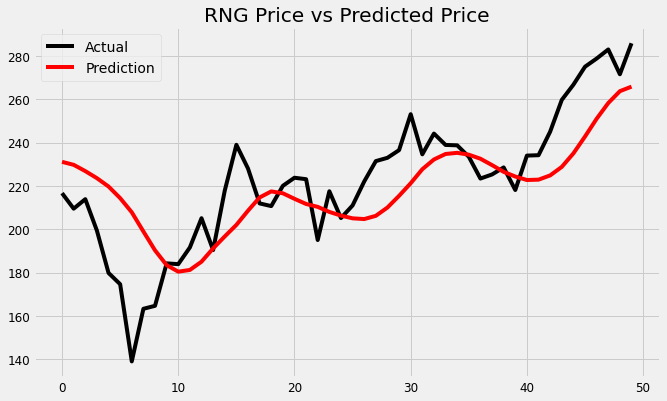

In [0]:
#merging the training set with the testing set
#setting the time step as 60
#MinMaxScaler to transform data set with test&train
test_inputs_total = pd.concat((training_price, testing_price), axis=0)
test_inputs = test_inputs_total[len(test_inputs_total) - len(testing_price) - 60:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

#aquiring the test features
test_features = []
for i in range(60, 110):
    test_features.append(test_inputs[i-60:i, 0])
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

#now predicting the model 
predictions = model.predict(test_features)

#need to scale data back
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(10,6))
plt.plot(testing_price.values, color='black', label='Actual')
plt.plot(predictions, color='red', label='Prediction')
plt.title('RNG Price vs Predicted Price')
plt.legend()
plt.show()